## Load libraries

In [1]:
library(plyr)
library(dplyr)
library(ggplot2)
library(reshape)
library(reshape2)
library(ggrastr)
library(ggrepel)
library(tidyverse)
library(RColorBrewer)
library(repr)

options(ggrepel.max.overlaps = Inf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr

## Set paths to reference files

In [2]:
cancers=c('ccRCC','CRC','CESC','HNSCC','UCEC','GBM','BRCA','OV','MM','PDAC','BRCA_Basal','MM','OV')

#Cancer-specific DACRs (from tumor vs CNC comparison), Supplementary Table S2e
path_to_ATAC_cancer_DACRs='../data/snATAC/Table_S2e_cancer_DACRs.txt'

#RNA Fold Changes, for Tumor vs CNC comparison
path_to_RNA_Fold_changes='../data/snRNA/RNA_Fold_changes_Tumor_vs_CNC_comparison.txt'

#ATAC cancer DACRs plotted in Fig. 2b
path_to_ATAC_cancer_DACRs_sel_2b='../data/snATAC/Cancer_DACRs_selected_for_plot_2b.txt'

## Set color scales

In [3]:
grad_color=(colorRampPalette(brewer.pal(9,"YlOrRd"),bias=2)(1000))

In [4]:
#Read cancer-specific DACRs
daps=read_delim(path_to_ATAC_cancer_DACRs,delim='\t',show_col_types = FALSE)
daps=as.data.frame(daps)
daps=daps[daps$p_val_adj<0.05,]
colnames(daps)[1]='Disease'

In [5]:
#Read RNA fold changes for Tumor vs CNC comparison (from the FindMarkers output before filtering)
fchs=read.table(path_to_RNA_Fold_changes, sep='\t', header=T)

In [6]:
#Merge RNA fold changes annotation to DACRs table
daps_s=daps[,c('p_val_adj', 'Disease','peak','Gene','avg_log2FC','DEL','AMP')]
fchs_s=fchs[,c('Disease','Gene','avg_log2FC')]
colnames(fchs_s)[3]='RNA_log2FC'

In [7]:
#Keep single DACRs with highest fold change for each gene
daps_s=daps_s[order(-abs(daps_s$avg_log2FC)),]
daps_s1=daps_s[!duplicated(daps_s[,c('Gene','Disease')]),]
res=merge(daps_s1,fchs_s)

In [8]:
#Filter table for selected cancers
sel_cancers=c('BRCA_Basal', 'ccRCC', 'CRC', 'GBM', 'MM', 'OV', 'PDAC', 'UCEC')
res_s=res[res$Disease %in% sel_cancers,]
colnames(res_s)[5]='ATAC_log2FC'

all_t1=res_s

In [9]:
#Add labels for DACRs plotted in Fig. 2b
sel_for_plot=read_delim(path_to_ATAC_cancer_DACRs_sel_2b, delim='\t', show_col_types = FALSE)
sel_for_plot=as.data.frame(sel_for_plot)
sel_for_plot=sel_for_plot[,c('peak','Peak_type','Gene'),]
sel_for_plot=sel_for_plot[!duplicated(sel_for_plot),]

all_t1$Label=ifelse(all_t1$peak %in% sel_for_plot$peak & all_t1$RNA_log2FC>0 & all_t1$ATAC_log2FC>0, all_t1$Gene,'')
tab=all_t1

In [10]:
all_fdrs=unique(tab$p_val_adj)
all_fdrs=all_fdrs[order(all_fdrs)]
min_fdr=all_fdrs[2]

#Assign min FDR to those with defined as 0 in the table
tab$p_val_adj=ifelse(tab$p_val_adj==0,min_fdr,tab$p_val_adj)
tab$neg_log10_FDR=-log10(tab$p_val_adj)

#Cap neg_log10_FDR at 50 
tab$neg_log10_FDR=ifelse(tab$neg_log10_FDR>50,50,tab$neg_log10_FDR)

## Do plotting

In [11]:
p <- ggplot(aes(ATAC_log2FC, RNA_log2FC),data=tab) 

p <- p + geom_point_rast(aes(color=neg_log10_FDR))

p <- p + geom_smooth(method="lm")+theme_classic()

p <- p + facet_wrap(Disease~.,scales = "free",nrow=2)

p <- p + ggpubr::stat_cor(method = "spearman", label.y = -2)

p <- p + scale_color_gradientn(colours=grad_color)

p <- p + geom_text_repel(aes(label=Label),min.segment.length = 0, box.padding = 0.7)

p <- p + theme(legend.position='bottom')

`geom_smooth()` using formula = 'y ~ x'


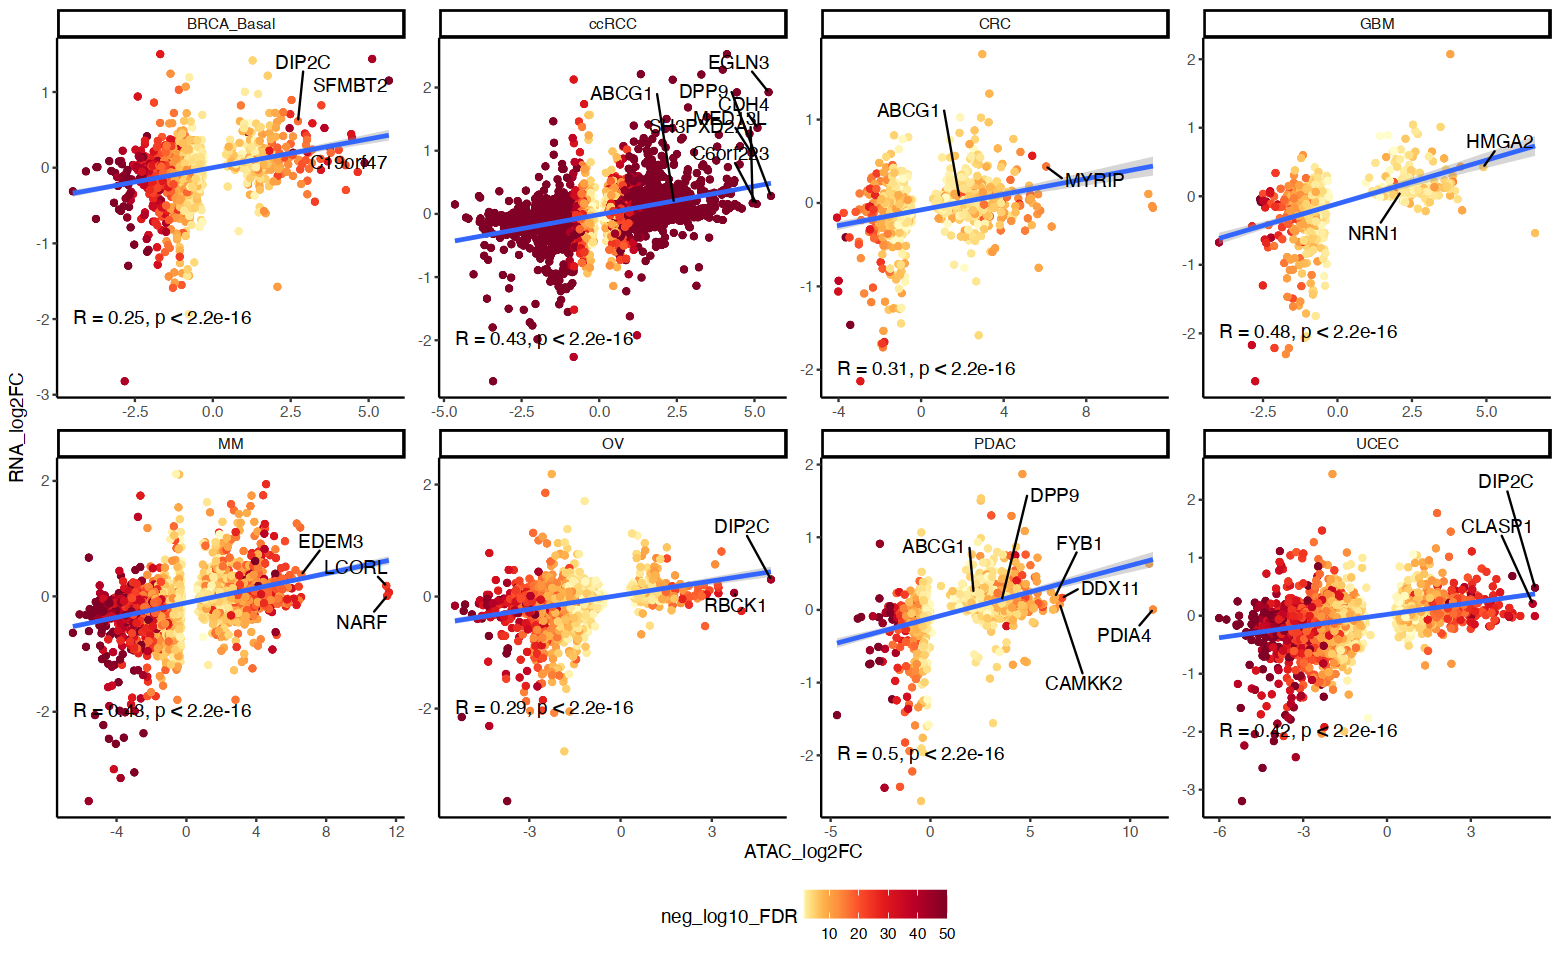

In [12]:
options(repr.plot.width=13, repr.plot.height=8)
p